In [1]:
%%capture

!pip install tensorflow-gan
import tensorflow_gan as tfgan

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tensorflowjs, witwidget


In [3]:
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Add, GlobalAveragePooling2D, Dense, Input, Conv2DTranspose, Reshape, Activation, Flatten, Embedding, Concatenate, AveragePooling2D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt


from generator_with_spectral_normalization import generator_network
from discriminator import discriminator_network
from classifier import classifier
from SpectralNormalization import SpectralNormalization

In [5]:
import wandb
import os

In [6]:
!pip freeze > requirements.txt


In [7]:
wandb.login(key = os.environ["WANDB_API_KEY"])

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
NUM_EPOCHS = 10
BUFFER_SIZE = 60000
BATCH_SIZE = 2


In [9]:
num_classes = 10

In [10]:
wandb.init(
      # Set the project where this run will be logged
      project="Triple-BiGGAN", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"Kaggle-Experiment-7",
      # Track hyperparameters and run metadata
      config={
      "architecture": "Triple-BiGGAN",
      "dataset": "CIFAR-10",
      "epochs": NUM_EPOCHS,
      })

wandb: Currently logged in as: rquaicoo (triple-big-gan). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230826_142500-0wvmqze7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run Kaggle-Experiment-7
wandb: ⭐️ View project at https://wandb.ai/triple-big-gan/Triple-BiGGAN
wandb: 🚀 View run at https://wandb.ai/triple-big-gan/Triple-BiGGAN/runs/0wvmqze7


In [11]:
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()
wandb.log({"training data": train_imgs})

170498071/170498071 [==============================] - 2s 0us/step


In [12]:
print(train_imgs.shape, test_imgs.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [13]:
np.random.seed(42)

# Generate random indices
random_indices = np.random.choice(len(train_imgs), size=1000, replace=False)

# Select random images and labels
random_train_imgs = train_imgs[random_indices]
random_train_labels = train_labels[random_indices]

In [14]:
random_indices_for_test = np.random.choice(len(test_imgs), size=100, replace=False)

# Select random images and labels
random_test_imgs = test_imgs[random_indices_for_test]
random_test_labels = test_labels[random_indices_for_test]

In [15]:
print("Shape of random_train_imgs:", random_train_imgs.shape)
print("Shape of random_train_labels:", random_train_labels.shape)

Shape of random_train_imgs: (1000, 32, 32, 3)
Shape of random_train_labels: (1000, 1)


In [16]:
# Resize images
resized_images = tf.image.resize(random_train_imgs, [256, 256])

In [17]:
resized_test_images = tf.image.resize(random_test_imgs, [256, 256])

In [18]:
print(resized_images.shape)

(1000, 256, 256, 3)


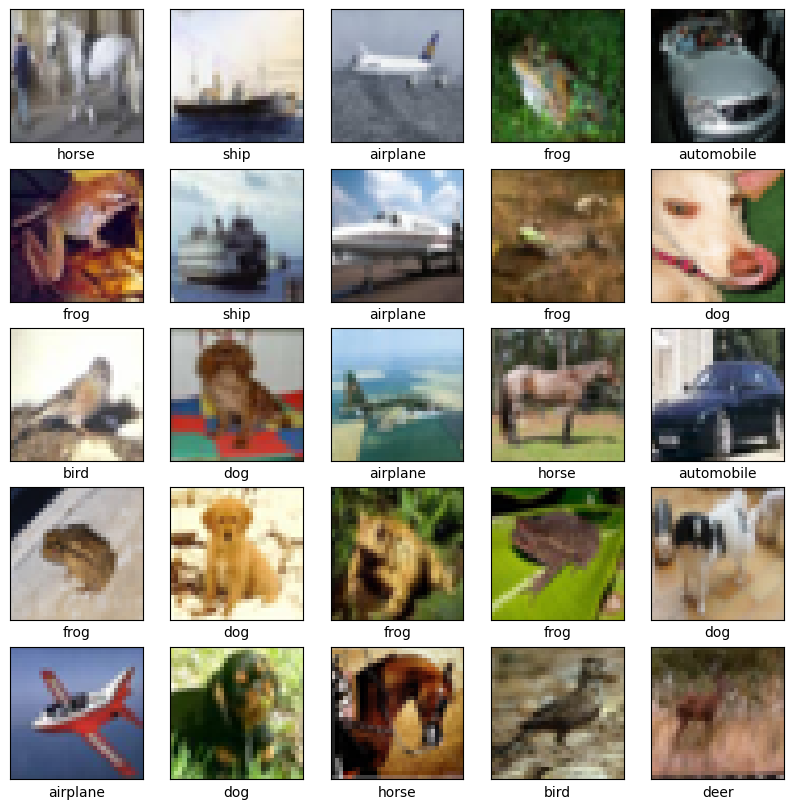

In [19]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(random_train_imgs[i])
  plt.xlabel(class_names[random_train_labels[i][0]])

plt.show()

In [20]:
#normalize resized images
normalized_resized_images = resized_images / 255.0

In [21]:
test_images = resized_test_images / 255.0

In [22]:
num_classes = 10
train_labels = tf.keras.utils.to_categorical(random_train_labels, num_classes)

In [23]:
test_labels = tf.keras.utils.to_categorical(random_test_labels, num_classes)

In [24]:
# Create a TensorFlow Dataset
#train_dataset = tf.data.Dataset.from_tensor_slices((resized_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices((resized_images, train_labels)).batch(BATCH_SIZE)

In [25]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

In [26]:
print(test_dataset
     )

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [28]:
classifier = classifier()

94765736/94765736 [==============================] - 1s 0us/step


In [34]:
generator = generator_network()

shape (None, 32768)
(None, 4, 4, 2048)
(None, 8, 8, 2048)
(None, 16, 16, 1024)
(None, 32, 32, 1024)
(None, 64, 64, 512)
(None, 128, 128, 256)
(None, 256, 256, 128)
(None, 256, 256, 3)


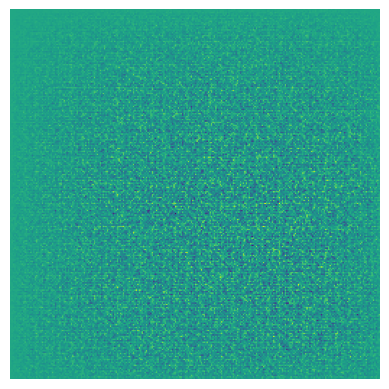

In [35]:
z_dim = 128
num_classes = 10
z = np.random.normal(size=(1, z_dim))
y = np.random.randint(0, num_classes, size=(1, num_classes))

generated_image = generator([z, y], training=False)


# Display the generated image
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()


In [38]:
discriminator = discriminator_network()

(None, 256, 256, 3)
(None, 128, 128, 128)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)
(None, 4, 4, 2048)
(None, 1, 1, 2048)
(None, 1)


In [39]:
generator_optimizer = Adam(learning_rate=0.00005, beta_1=0, beta_2=0.999)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)
classifier_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)

In [40]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def calculate_classifier_loss(true_labels, predicted_labels):
  loss = tf.keras.losses.categorical_crossentropy(true_labels, predicted_labels)
  return loss

def calculate_generator_loss(fake_output):
  loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)

  return loss

def calculate_discriminator_loss(real_output, fake_output):
  real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)

  return real_loss + fake_loss

In [41]:
classifier.compile(optimizer=classifier_optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
generator.compile(optimizer=generator_optimizer, )
discriminator.compile(optimizer=discriminator_optimizer,)

In [42]:
num_classes = 10
z_dim = 128
batch_size = 2


random_labels = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)
class_embeddings = tf.one_hot(random_labels, depth=num_classes)

@tf.function
def train_step(images, labels):

    # Generate noise vector and random class embeddings
    noise = tf.random.normal([batch_size, z_dim])
    print(class_embeddings, random_labels)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as class_tape:
        # Train the generator
        print("Training generator")
        generated_images = generator([noise, class_embeddings], training=True)

        # Train the discriminator
        print("Training discriminator with real input")
        real_output = discriminator([images, labels], training=True)

        print("Training the discriminator with fake input")
        fake_output = discriminator([generated_images, class_embeddings], training=True)

        # Classifier outputs for real and fake images
        print("Training classifier")
        predicted_labels = classifier(images, training = True)
        #fake_class_output = classifier(generated_images)

        # Calculate losses
        gen_loss = calculate_generator_loss(fake_output)
        disc_loss = calculate_discriminator_loss(real_output, fake_output)
        class_loss = calculate_classifier_loss(labels, predicted_labels)

    print("Calculating gradients")
    # Calculate gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    class_gradients = class_tape.gradient(class_loss, classifier.trainable_variables)

    print("applying gradients")
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    classifier_optimizer.apply_gradients(zip(class_gradients, classifier.trainable_variables))
    
    return gen_loss, disc_loss, class_loss


In [43]:
print(test_labels.shape)

(100, 10)


In [44]:
def generate_fake_images(num_images):
    noise = tf.random.normal([num_images, z_dim])
    random_labels = tf.random.uniform([num_images], minval=0, maxval=num_classes, dtype=tf.int32)
    class_embeddings = tf.one_hot(random_labels, depth=num_classes)
   
    fake_images = generator([noise, class_embeddings], training=False)
    return fake_images

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(2, 10), dtype=float32) tf.Tensor([1 4], shape=(2,), dtype=int32)
Training generator
Training discriminator with real input
Training the discriminator with fake input
Training classifier
Calculating gradients
applying gradients
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(2, 10), dtype=float32) tf.Tensor([1 4], shape=(2,), dtype=int32)
Training generator
Training discriminator with real input
Training the discriminator with fake input
Training classifier
Calculating gradients
applying gradients


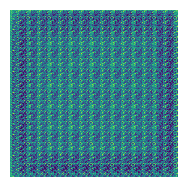

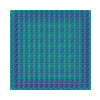

Time for epoch 1 is 765.1624052524567 sec


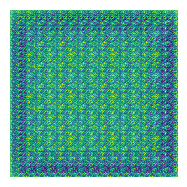

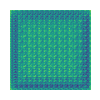

Time for epoch 2 is 697.951192855835 sec


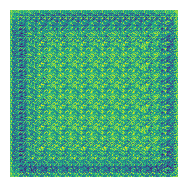

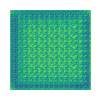

Time for epoch 3 is 697.5646440982819 sec


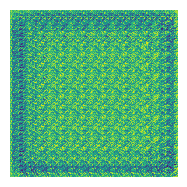

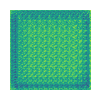

Time for epoch 4 is 698.1741383075714 sec


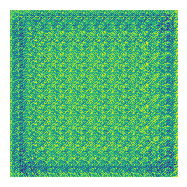

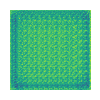

Time for epoch 5 is 697.6307032108307 sec


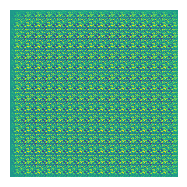

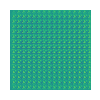

Time for epoch 6 is 697.7994883060455 sec


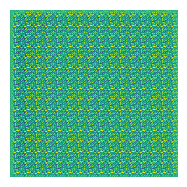

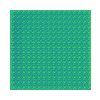

Time for epoch 7 is 696.2856884002686 sec


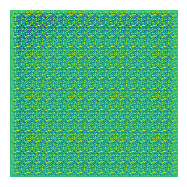

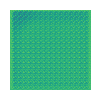

Time for epoch 8 is 696.9433009624481 sec


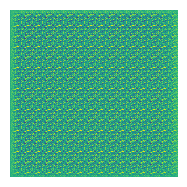

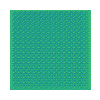

Time for epoch 9 is 696.9938888549805 sec


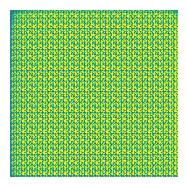

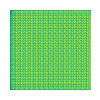

Time for epoch 10 is 696.2895429134369 sec


wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: class_loss █▅▃▂▂▂▁▁▁▁
wandb:  disc_loss █▁▁▁▁▁▁▁▁▁
wandb:      epoch ▁▂▃▃▄▅▆▆▇█
wandb:   gen_loss ▁▃▄▅▅▇█▇▇█
wandb: 
wandb: Run summary:
wandb: class_loss 0.0678
wandb:  disc_loss 0.0
wandb:      epoch 9
wandb:   gen_loss 22.90302
wandb: 
wandb: 🚀 View run Kaggle-Experiment-7 at: https://wandb.ai/triple-big-gan/Triple-BiGGAN/runs/0wvmqze7
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230826_142500-0wvmqze7/logs


In [45]:
# Training loop
for epoch in range(NUM_EPOCHS):
    gen_train_loss = []
    disc_train_loss = []
    class_train_loss = []
    
    
    start = time.time()
    for real_images, real_labels in train_dataset:
        generator_loss, discriminator_loss, classifier_loss = train_step(real_images, real_labels)
        
        #class_test_loss, class_test_accuracy = model.evaluate(test_dataset)
        #print(class_test_loss, class_test_accuracy)
        
        gen_train_loss.append(float(generator_loss))
        disc_train_loss.append(float(discriminator_loss))
        
        for loss in classifier_loss:
            class_train_loss.append(float(loss))

        #print(f"Epoch {epoch+1}/{num_epochs}")
        #print()
    
    images = generate_fake_images(2)
    fig = plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0])
        plt.axis('off')
        plt.show()
        
    generator.save_weights(f'generator_model_{epoch}.h5')
    discriminator.save_weights(f'discriminator_model_{epoch}.h5')
    classifier.save_weights(f'classifier_model_{epoch}.h5')

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    wandb.log({'epoch': epoch,
           'gen_loss': np.mean(gen_train_loss),
           'disc_loss': np.mean(disc_train_loss),
            'class_loss': np.mean(class_train_loss)
            })
    
  

# Save the trained models
generator.save_weights('generator_model.h5')
discriminator.save_weights('discriminator_model.h5')
classifier.save_weights('classifier_model.h5')

wandb.finish()



In [46]:
def generate_fake_images(num_images):
    noise = tf.random.normal([num_images, z_dim])
    random_labels = tf.random.uniform([num_images], minval=0, maxval=num_classes, dtype=tf.int32)
    class_embeddings = tf.one_hot(random_labels, depth=num_classes)
   
    fake_images = generator([noise, class_embeddings], training=False)
    return fake_images

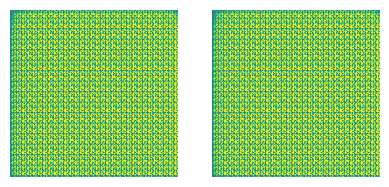

In [47]:
images = generate_fake_images(2)
fig = plt.figure(figsize=(10, 10))

for i in range(images.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(images[i, :, :, 0])
  plt.axis('off')



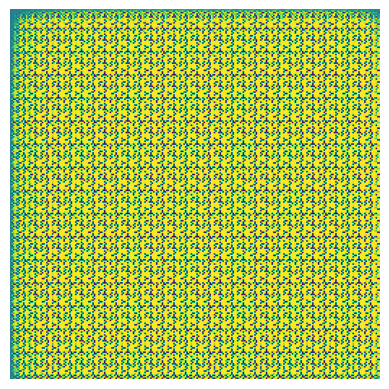

In [48]:
z_dim = 128
num_classes = 10
z = np.random.normal(size=(1, z_dim))
y = np.random.randint(0, num_classes, size=(1, num_classes))

generated_image = generator([z, y], training=False)


# Display the generated image
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()


In [49]:
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [50]:
loss, acc = classifier.evaluate(test_dataset)

50/50 [==============================] - 3s 17ms/step - loss: 7.0373 - accuracy: 0.1300


In [51]:
print(loss, acc)

7.037332057952881 0.12999999523162842


In [52]:
import os
os.path.getsize('discriminator_model.h5')

706247260

In [53]:
!ls

__notebook__.ipynb     discriminator_model.h5	 generator_model_0.h5
classifier_model.h5    discriminator_model_0.h5  generator_model_1.h5
classifier_model_0.h5  discriminator_model_1.h5  generator_model_2.h5
classifier_model_1.h5  discriminator_model_2.h5  generator_model_3.h5
classifier_model_2.h5  discriminator_model_3.h5  generator_model_4.h5
classifier_model_3.h5  discriminator_model_4.h5  generator_model_5.h5
classifier_model_4.h5  discriminator_model_5.h5  generator_model_6.h5
classifier_model_5.h5  discriminator_model_6.h5  generator_model_7.h5
classifier_model_6.h5  discriminator_model_7.h5  generator_model_8.h5
classifier_model_7.h5  discriminator_model_8.h5  generator_model_9.h5
classifier_model_8.h5  discriminator_model_9.h5  requirements.txt
classifier_model_9.h5  generator_model.h5	 wandb


In [54]:
from IPython.display import FileLink

In [55]:
FileLink('discriminator_model.h5')

/kaggle/working/discriminator_model.h5

In [56]:
FileLink('generator_model.h5')

/kaggle/working/generator_model.h5

In [57]:
FileLink('classifier_model.h5')

/kaggle/working/classifier_model.h5